# 프로젝트 : Segmentation map으로 도로 이미지 만들기

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.: 데이터 분석 과정 및 1가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.: U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.:
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.: 10 epoch 이상의 학습을 진행한 후 최종 테스트결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

- 프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

    1. 데이터에 1 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요).
    2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
    3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내에서 아무 이미지나 사용해주세요.
    4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 (스케치, 생성된 사진, 실제 사진) 순서로 나란히 시각화해 주세요.
    5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요.
- 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

# Segmentation map 도로 이미지 (1) 데이터 준비하기

- 이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

- 이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드 할 수 있습니다.
- 1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

![title](p2p_result_seg.max-800x600.png) 

- cityscapes.zip 
- 이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
- 아래 Tensorflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

- 프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.
- (아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

- Tensorflow Pix2Pix Tutorial


In [1]:
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- 1000개 이미지가 있음을 확인할 수 있습니다.

- 이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 봅시다. 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.



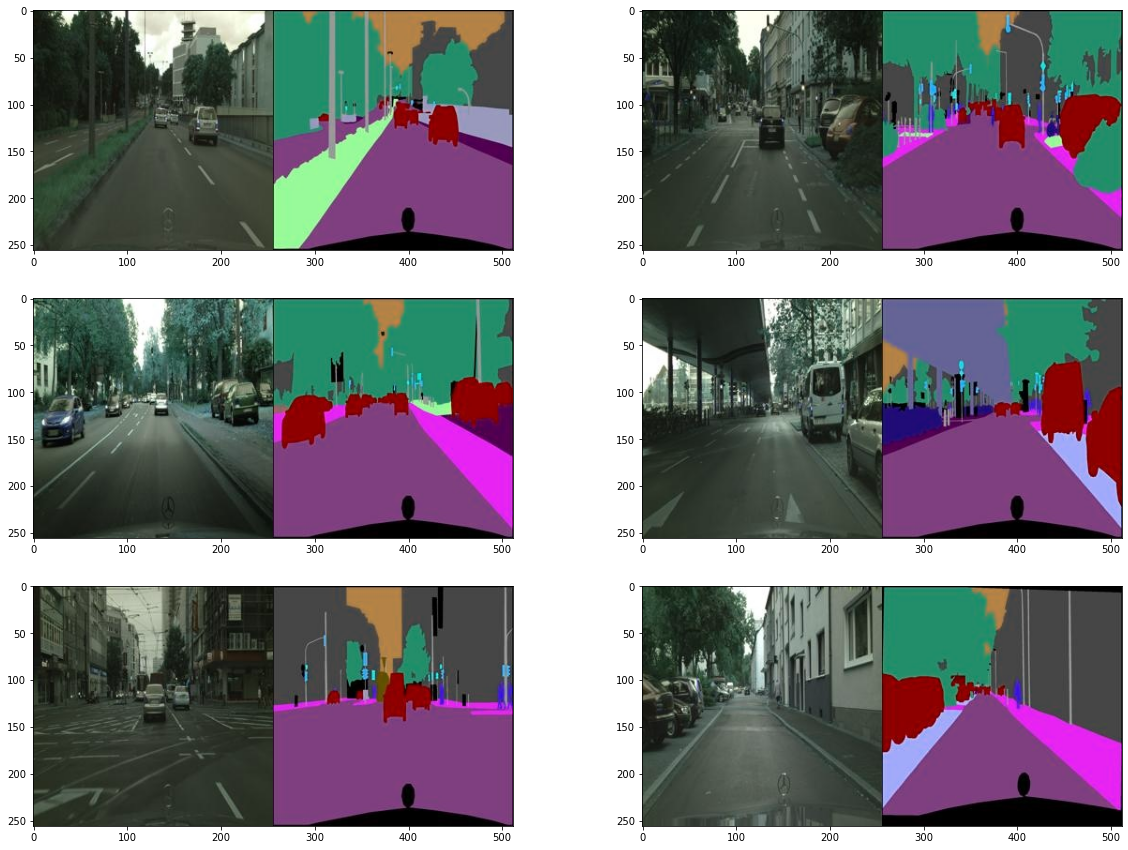

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 하나의 이미지에 도로의 레이블 이미지와 실제 도로 이미지가 함께 포함되어 있음을 확인할 수 있습니다.

- 이미지를 하나 열어 아래와 같이 크기를 확인해 보겠습니다.

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- (256, 512, 3)으로 확인되었습니다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같네요.
- 아래 코드로 이미지를 나누어 봅시다.
- 이 때 도로 레이블 이미지를 입력으로 실제 도로 이미지를 생성하는 것이므로, 학습 노드에 있는 예제에서의 sketch와 colored 순서를 바꿔줍니다. 

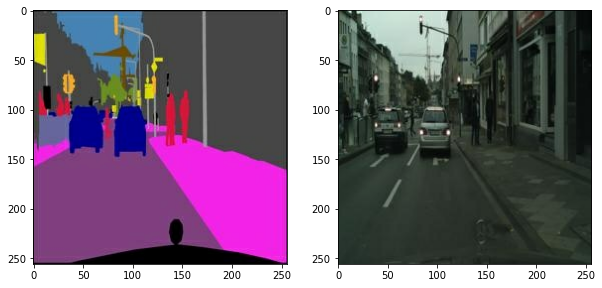

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)

    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

- 위와 같이 두개 이미지로 나누었습니다. 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표입니다.

- 앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 1000개 뿐입니다.

- 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.
- apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러가지 연산을 두 이미지에 동일하게 적용합니다.
- 아래에 정의한 apply_augmentation 함수에 두 이미지가 입력되면 아래와 같은 과정을 순서대로 진행합니다.
    1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    - 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    - 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop) 
    - 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    - 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down) 
    - 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
    - 6.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot45)


In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

 - 위와 같이 구성한 함수를 데이터에 적용해 시각화 해봅시다.

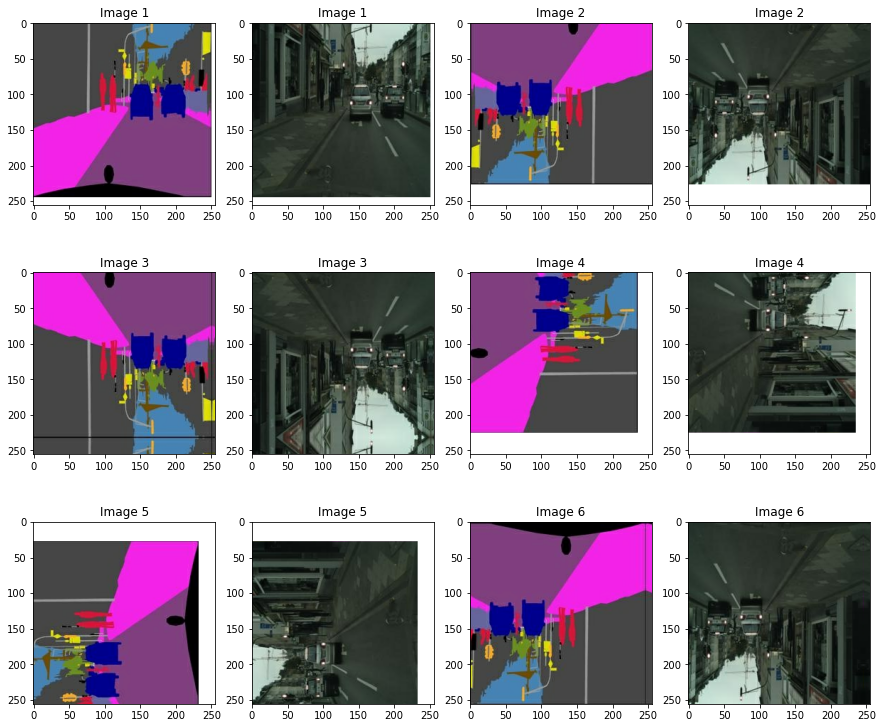

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 매우 다양한 이미지가 생성됩니다. 
- 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱 더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있습니다.
- 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용 되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

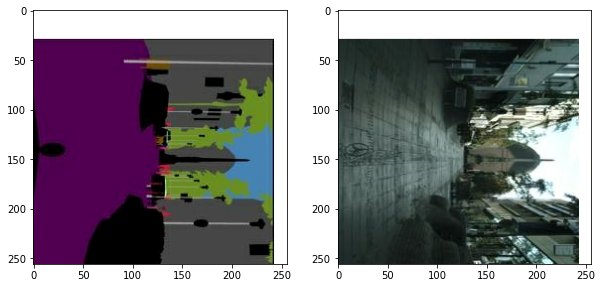

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 난 스케치를 할테니 너는 채색을 하거라 (2) Generator 구성하기
- 이제부터 본격적으로 Pix2Pix 구조를 구현합니다. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠습니다.

- (주의) 커널 메모리를 체크해 주세요!
- 이전 모델이 메모리에 로드되어 있는 상태에서 pix2pix 모델을 함께 학습하면 메모리 오류가 발생할 수도 있습니다. 메모리가 충분하지 않다면 이 시점에 커널 재시작 후 진행할 것을 권합니다.

## Generator의 구성요소 알아보기
- 먼저, pix2pix 논문에서 Generator를 구성하는데 필요한 정보를 아래에 가져왔습니다. 한번 읽어보시고 아래 질문에 답해봅시다.

![title](paper_g.png)

- 논문에서 표기한 encoder의 "C64"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나요?
    - 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU (위 논문의 아래 단락에 BatchNorm을 사용하지 않는다고 쓰여 있습니다)

- 논문에서 표기한 decoder의 "CD512"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나요?
    - 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU
    
- 아마도 위 두 개의 질문에 잘 답하셨다면, Generator를 구성하는데 필요한 레이어들은 대략적으로 숙지하셨으리라 생각됩니다.
- 이번에는 아래와 같이 보기 쉽게 표현한 그림을 통해 Generator의 전체 구조를 머리 속에 조금 더 자세히 그려봅시다.

![title](refer_g.max-800x600.png)

- 위 그림에서 ENCODE 또는 DECODE라고 쓰인 각각의 블럭을 기준으로 양쪽에 쓰인 입출력 크기에 집중해주세요.
- "in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고,
- 채널의 수는 512까지 늘어나는 것을 확인할 수 있습니다.
- 처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분 입니다.

- 이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 됩니다.
- (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분입니다.

## Generator 구현하기
- 위 정보들을 토대로 여러분의 머릿속에 희미하게 그려진 Generator의 Encoder 부분을 구현하겠습니다.
- 먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었습니다.

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

- __init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있습니다.
- 이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했습니다.
- Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있습니다.

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과합니다.
- 앞서 퀴즈로 알아본 것 처럼 Encoder 첫번째 블록에서는 BatchNorm을 사용하지 않습니다.
- get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았습니다.
- 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅시다. 만들어 놓은 get_summary 메서드를 바로 불러오시면 됩니다.

In [10]:
Encoder().get_summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)        

- 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있습니다.

- 이번엔 Decoder를 구현합니다. Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러번 반복하여 아래와 같이 Decoder를 만들겠습니다.

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- 처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있습니다.
- 마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해봅시다.

In [12]:
Decoder().get_summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)      

- (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었습니다.

- 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있겠군요. 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있습니다.
- 아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해봅시다.



In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만개의 파라미터를 잘 학습시켜야 합니다.

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

# 난 스케치를 할테니 너는 채색을 하거라 (3) Generator 재구성하기
- 지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤습니다.
- 하지만 앞서 설명드린 것 처럼 Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지를 제안했습니다.
- 아래 그림으로 다시 한번 봅시다.

- 위 그림에서 각 구조 아래에 표시된 이미지는 해당 구조를 Generator로 사용했을 때의 결과입니다.

- 단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다.

- 이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조입니다.
- Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다.
- 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해봅시다.
- (아래 단락 부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용하겠습니다)

- 먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었습니다.

In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


- 여기서 특별히 수정해야 할 부분은 없습니다. 그대로 가져다가 사용하겠습니다.

- 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의해 보겠습니다. 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고,
- call()에서 forward propagation 하도록 합니다. 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해봅시다.

- 먼저, __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.
- 이 때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.
- 이 후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
- features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.

- 아래 질문에 답하면서 조금 더 자세히 이해해봅시다.
- 위 코드의 call() 내에서 ' features = features[:-1]' 는 왜 필요할까요?
    - Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.
- 위 코드의 call() 내의 Decoder 연산 부분에서 features[::-1] 는 왜 필요할까요?
    - Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다(맨 위 U-Net 구조 사진 참고). 
    - features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.

- 아래와 같은 데이터 A, B가 있을 때, 
    - 데이터 A 크기 : (32,128,128,200) #(batch, width, height, channel)
    - 데이터 B 크기 : (32,128,128,400) #(batch, width, height, channel)
    - 여기서 사용되는 skip connection은 layers.Concatenate() 결과의 크기는 무엇일까요?
    - (128,128,600)
    - layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결됩니다.    

- 이제야 Generator 구현이 끝났습니다.

- 마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해봅시다.

In [16]:
UNetGenerator().get_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
_______________________________________________________________________________________

- 이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만개 였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만개로 꽤나 많이 늘어났습니다.
- U-Net Generator의 파라미터가 늘어난 곳은 Encoder와 Decoder 중 어디일까요?
- 또한, 두 종류의 Generator 구조에서 동일한 수의 convolution 레이어를 사용했는데, 구체적으로 어느 부분에서 파라미터가 늘어났을까요?
    - U-Net Generator의 Decoder 구조 내 파라미터가 많아졌습니다. 이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다릅니다. 
    - 예를 들어, 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면,
    - Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 입니다.
    - U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 입니다.
- 정리하면, U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력 받는 채널 수가 늘어났고,
- 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났습니다.

# 난 스케치를 할테니 너는 채색을 하거라 (4) Discriminator 구성하기
- Generator만으로 좋은 결과를 도출하기에는 부족합니다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다.
- 이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 봅시다.

## Discriminator의 구성요소 알아보기
- Generator를 만들기 전에 봤듯이 먼저 Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보를 아래에 가져왔습니다.

![title](paper_d.png)

- Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어있습니다.
- 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같습니다.

- 이어서 아래의 보기 쉽게 표현한 그림을 통해 Discriminator의 구조를 머리 속에 조금 더 자세히 그려봅시다.

![title](refer_d.max-800x600.png)

- Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과합니다.
- 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었습니다.

- 최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있습니다.
- Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것입니다.
- 1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 같네요.🤔
- 이 부분이 지금 이해되지 않는다면 아래 코드에서 다시 다룰테니 우선 넘어갑시다.

- 추가적으로 위 그림에서 최종 출력 크기가 (30,30)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문입니다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다.
- 이 부분에 대한 설명은 아래 참고 자료로 대신하겠습니다. (아래 글 마지막 부분에 언급합니다)

- Understanding PatchGAN
- 이 부분만 제외하면 전반적으로는 Generator보다 간단한 것 같습니다. 구현해봅시다.

## Discriminator 구현하기
마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들겠습니다.



In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

- __init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다.
- 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad),
- BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다.

- 아래 질문에 답하면서 위 코드가 어떻게 동작하는지 생각해봅시다.
- 다음의 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 설정으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력된다면, 블록 내부에서 순서대로 어떠한 레이어를 통과하는지, 그리고 각 레이어를 통과했을 때 출력 크기는 어떻게 되는지 적어주세요.
    1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)  
    2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)  
    3. BatchNormalization 레이어 통과  layers.BatchNormalization() → (127,127,64)  
    4. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)
    
- 이전 Discriminator를 표현한 그림에서 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 언급했었습니다.
- 1씩 감소시키기 위한 방법이 위 질문의 답이며, 이에 대해 자세히 설명해보겠습니다.

    1. (128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어납니다. 출력 : (130,130,32)
    2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듭니다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있습니다. 채널 수는 사용한 필터 개수와 같습니다. 출력 : (127,127,64)
    3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않습니다.
- 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 봅시다.

In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


- 이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있습니다. 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 되겠습니다.

- Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했습니다.
- 사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어봅시다.

In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


- __init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들 처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만,
- 쉽게 코드를 읽게 끔 총 6개 블록을 각각 따로 만들었습니다.
- 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했습니다.
- 각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해봅시다.

In [20]:
Discriminator().get_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]  

- 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치합니다.

![title](refer_d.max-800x600.png)

- 시험삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보겠습니다.

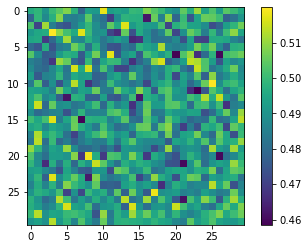

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- 이전 PatchGAN에 대해 설명했던 것 처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70,70) 패치에 대한 분류 결과 입니다.
- 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠.
- 각각의 픽셀값은 sigmoid 함수의 결과값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는데 사용합니다.

- 드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났습니다.
- 다음 단계에서 본격적인 모델 학습을 진행해 봅시다!

# 난 스케치를 할테니 너는 채색을 하거라 (5) 학습 및 테스트하기
- 이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해 봅시다. 먼저 학습에 필요한 손실함수 부터 정의하겠습니다.
- 논문의 여러 실험 결과 중 손실함수 선택에 따른 결과의 차이는 아래와 같습니다.

![title](p2p_result_loss2.max-800x600.png)

- 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때
- 가장 실제에 가까운 이미지를 생성해 냈습니다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 봅시다.


In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


- Generator 및 Discriminator의 손실 계산을 각각 정의했습니다.

    - Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다.
    - 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다.
    - 또한 L1 손실을 계산하기 위해 생성한 가짜이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.

    - Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다.
    - Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

- 사용할 optimizer는 논문과 동일하게 아래와 같이 설정합니다.



In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


- 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트 하는 과정은 아래와 같이 구현했습니다.

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

- 전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않습니다.
- 다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인 하셨나요? (## 이 표시가 있는 부분을 확인해 주세요.) 논문에서는 Generator의 손실을 아래와 같이 정의했습니다.
    
![title](Generator_loss.png)    

- 위 식에서 λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100 을 사용했습니다.

- 앞서 정의한 함수를 이용해서 학습을 진행합니다. 우선 10 epoch 학습해 봅시다.

In [25]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9677                     
L1_loss:0.3224                     
Discriminator_loss:1.3712

EPOCH[1] - STEP[20]                     
Generator_loss:1.1970                     
L1_loss:0.2414                     
Discriminator_loss:1.2526

EPOCH[1] - STEP[30]                     
Generator_loss:0.9296                     
L1_loss:0.2137                     
Discriminator_loss:1.3542

EPOCH[1] - STEP[40]                     
Generator_loss:0.8772                     
L1_loss:0.2408                     
Discriminator_loss:1.3724

EPOCH[1] - STEP[50]                     
Generator_loss:0.7664                     
L1_loss:0.2196                     
Discriminator_loss:1.2489

EPOCH[1] - STEP[60]                     
Generator_loss:0.9907                     
L1_loss:0.1804                     
Discriminator_loss:1.2519

EPOCH[1] - STEP[70]                     
Generator_loss:0.9239                     
L1_loss:0.1673                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.4940                     
L1_loss:0.1679                     
Discriminator_loss:1.0366

EPOCH[3] - STEP[80]                     
Generator_loss:1.0562                     
L1_loss:0.1721                     
Discriminator_loss:0.9343

EPOCH[3] - STEP[90]                     
Generator_loss:1.7081                     
L1_loss:0.1510                     
Discriminator_loss:0.7031

EPOCH[3] - STEP[100]                     
Generator_loss:1.3005                     
L1_loss:0.2045                     
Discriminator_loss:0.4677

EPOCH[3] - STEP[110]                     
Generator_loss:1.7846                     
L1_loss:0.1932                     
Discriminator_loss:0.4521

EPOCH[3] - STEP[120]                     
Generator_loss:1.7618                     
L1_loss:0.2155                     
Discriminator_loss:1.0767

EPOCH[3] - STEP[130]                     
Generator_loss:1.8938                     
L1_loss:0.1509                

EPOCH[5] - STEP[130]                     
Generator_loss:0.8645                     
L1_loss:0.1845                     
Discriminator_loss:0.8151

EPOCH[5] - STEP[140]                     
Generator_loss:1.3138                     
L1_loss:0.1896                     
Discriminator_loss:0.4904

EPOCH[5] - STEP[150]                     
Generator_loss:1.6523                     
L1_loss:0.1935                     
Discriminator_loss:0.5305

EPOCH[5] - STEP[160]                     
Generator_loss:0.2087                     
L1_loss:0.1904                     
Discriminator_loss:1.8538

EPOCH[5] - STEP[170]                     
Generator_loss:0.8973                     
L1_loss:0.1621                     
Discriminator_loss:0.9392

EPOCH[5] - STEP[180]                     
Generator_loss:2.1923                     
L1_loss:0.2070                     
Discriminator_loss:0.2723

EPOCH[5] - STEP[190]                     
Generator_loss:1.3016                     
L1_loss:0.1737             

EPOCH[7] - STEP[190]                     
Generator_loss:1.1955                     
L1_loss:0.1814                     
Discriminator_loss:0.8408

EPOCH[7] - STEP[200]                     
Generator_loss:1.2296                     
L1_loss:0.1889                     
Discriminator_loss:1.5936

EPOCH[7] - STEP[210]                     
Generator_loss:1.8507                     
L1_loss:0.1695                     
Discriminator_loss:1.5006

EPOCH[7] - STEP[220]                     
Generator_loss:1.5708                     
L1_loss:0.1522                     
Discriminator_loss:0.7695

EPOCH[7] - STEP[230]                     
Generator_loss:1.1545                     
L1_loss:0.1650                     
Discriminator_loss:0.6352

EPOCH[7] - STEP[240]                     
Generator_loss:2.2247                     
L1_loss:0.1772                     
Discriminator_loss:0.4024

EPOCH[7] - STEP[250]                     
Generator_loss:2.6031                     
L1_loss:0.2008             

EPOCH[9] - STEP[250]                     
Generator_loss:2.2619                     
L1_loss:0.1909                     
Discriminator_loss:0.3486

EPOCH[10] - STEP[10]                     
Generator_loss:0.6893                     
L1_loss:0.1661                     
Discriminator_loss:1.2769

EPOCH[10] - STEP[20]                     
Generator_loss:1.8909                     
L1_loss:0.1382                     
Discriminator_loss:1.8777

EPOCH[10] - STEP[30]                     
Generator_loss:1.4808                     
L1_loss:0.1797                     
Discriminator_loss:0.6674

EPOCH[10] - STEP[40]                     
Generator_loss:1.7822                     
L1_loss:0.1629                     
Discriminator_loss:1.9002

EPOCH[10] - STEP[50]                     
Generator_loss:1.3238                     
L1_loss:0.2021                     
Discriminator_loss:0.4353

EPOCH[10] - STEP[60]                     
Generator_loss:2.2741                     
L1_loss:0.1617             

- 10 Epoch 이상을 학습시키면서 다양하게 실험을 진행합니다. 

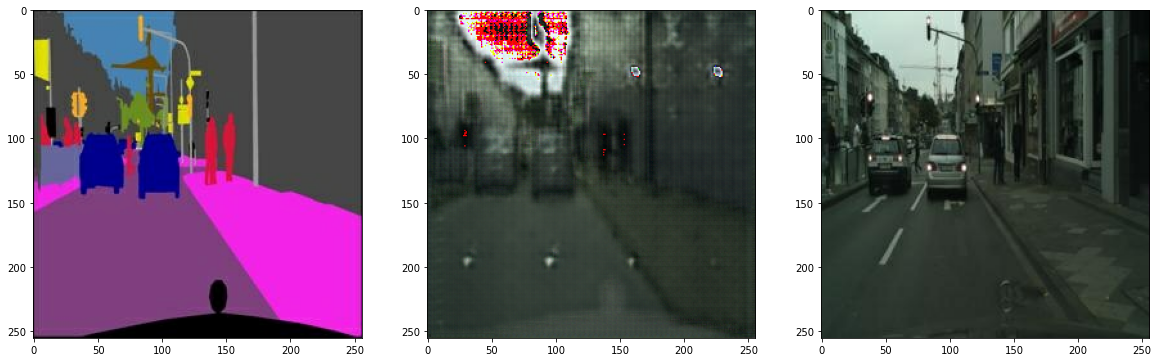

In [27]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

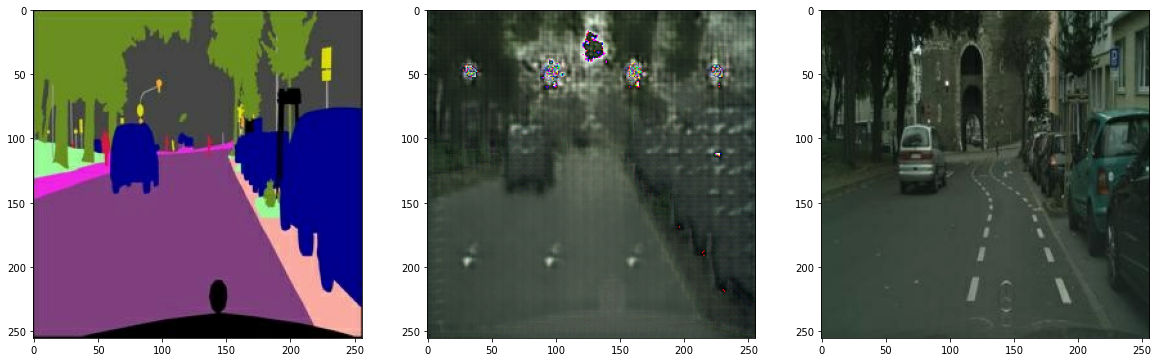

In [28]:
test_ind = 2

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

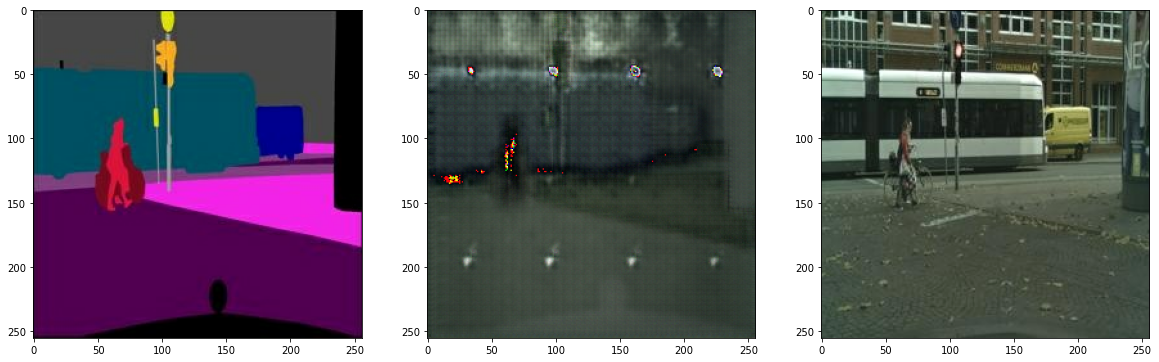

In [29]:
test_ind = 3

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

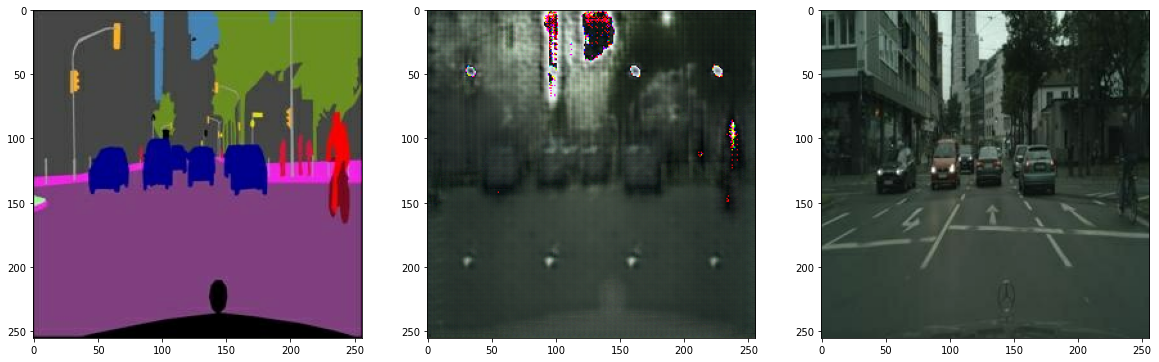

In [30]:
test_ind = 4

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

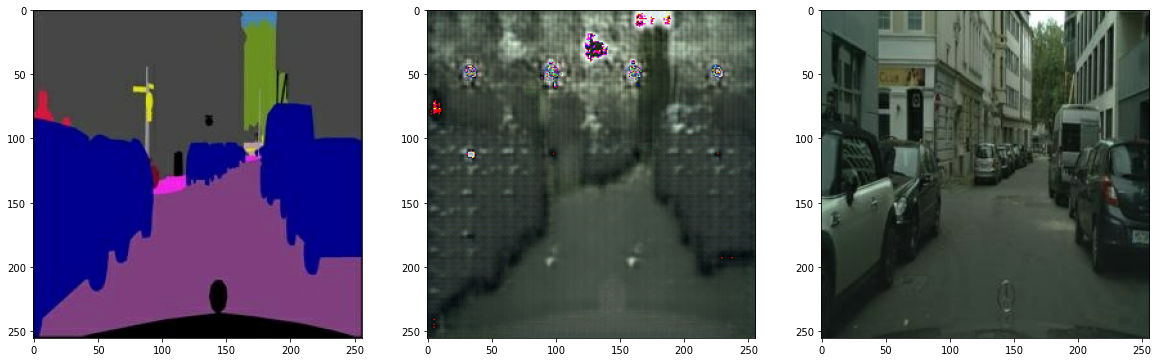

In [31]:
test_ind = 5

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 학습전제
1. 신경망의 학습 방법에 대한 전반적인 절차를 알고 있어야 합니다.
2. CNN, GAN에 대한 기본적인 개념을 알고 있어야 합니다.
3. Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법에 대해 대략적으로 알고 있어야 합니다.
4. Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해할 수 있어야 합니다.
5. (중요) Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해보려는 의지가 필요합니다.

# 학습목표
1. 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다.
2. cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다.
3. CNN 기반의 모델을 구현하는데 자신감을 갖습니다.

# 결론
- 조건을 부여하면서 생성모델을 다루는 cGAN에 대해서 체계적으로 배울 수 있어서 재미있었습니다. 
- 이미지를 다양한 방식으로 augmentation 하는 방법을 적용해 보았습니다. 
- 생성모델은 확실히 학습을 많이 할 수록 결과가 좋아히즌 것을 파악할 수 있었습니다. 